In [ ]:
import tensorflow as tf

import keras
from keras import layers

import numpy as np

from matplotlib import pyplot as plt

from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score

np.random.seed(42)
tf.random.set_seed(42)

2025-04-09 22:39:33.572898: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1744231173.616103  147234 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1744231173.629088  147234 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-04-09 22:39:33.694124: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
LATENT_DIM = 10

In [4]:
fashion_mnist = tf.keras.datasets.fashion_mnist.load_data()
(X_train_full, y_train_full), (X_test, y_test) = fashion_mnist

In [5]:
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()
x_train = x_train.astype("float32") / 255
x_test = x_test.astype("float32") / 255

In [40]:
class Sampling(layers.Layer):
    def call(self, inputs):
        mean, log_var = inputs
        return tf.random.normal(tf.shape(log_var)) * tf.exp(log_var / 2) + mean 

In [41]:
inputs = layers.Input(shape=(28, 28))
Z = layers.Flatten()(inputs)
Z = layers.Dense(150, activation="relu")(Z)
Z = layers.Dense(100, activation="relu")(Z)
codings_mean = layers.Dense(LATENT_DIM)(Z)  # μ
codings_log_var = layers.Dense(LATENT_DIM)(Z)  # γ
codings = Sampling()([codings_mean, codings_log_var])
variational_encoder = keras.Model(
    inputs=inputs, outputs=[codings_mean, codings_log_var, codings])

In [42]:
decoder_inputs = layers.Input(shape=[LATENT_DIM])
x = layers.Dense(100, activation="relu")(decoder_inputs)
x = layers.Dense(150, activation="relu")(x)
x = layers.Dense(28 * 28)(x)
outputs = layers.Reshape((28, 28))(x)
variational_decoder = keras.Model(inputs=decoder_inputs, outputs=outputs)

In [43]:
class VAELossLayer(layers.Layer):
    def __init__(self, beta=5, **kwargs):
        super(VAELossLayer, self).__init__(**kwargs)
        self.beta = beta

    def call(self, codings_mean, codings_log_var, reconstructions):
        latent_loss = -0.5 * tf.reduce_sum(
            1 + codings_log_var - tf.exp(codings_log_var) - tf.square(codings_mean), axis=-1
        )

        self.add_loss(tf.reduce_mean(latent_loss) / 784.0)

        return reconstructions

In [44]:
codings_mean, codings_log_var, codings = variational_encoder(inputs)
reconstructions = variational_decoder(codings)
outputs = VAELossLayer()(codings_mean, codings_log_var, reconstructions)
variational_ae = keras.Model(inputs=inputs, outputs=outputs)

In [45]:
variational_ae.compile(loss="mse", optimizer=tf.keras.optimizers.Nadam())
history = variational_ae.fit(
    x_train, x_train, epochs=25, batch_size=128, validation_data=(x_test, x_test)
)

Epoch 1/25
469/469 ━━━━━━━━━━━━━━━━━━━━ 10s 12ms/step - loss: 0.0661 - val_loss: 0.0464
Epoch 2/25
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0456 - val_loss: 0.0433
Epoch 3/25
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0432 - val_loss: 0.0420
Epoch 4/25
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0421 - val_loss: 0.0412
Epoch 5/25
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0414 - val_loss: 0.0408
Epoch 6/25
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0409 - val_loss: 0.0404
Epoch 7/25
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0405 - val_loss: 0.0400
Epoch 8/25
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0401 - val_loss: 0.0397
Epoch 9/25
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0399 - val_loss: 0.0395
Epoch 10/25
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0397 - val_loss: 0.0394
Epoch 11/25
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0395 - val_loss: 0.0391
Epoch 12/25
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/st

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 470ms/step


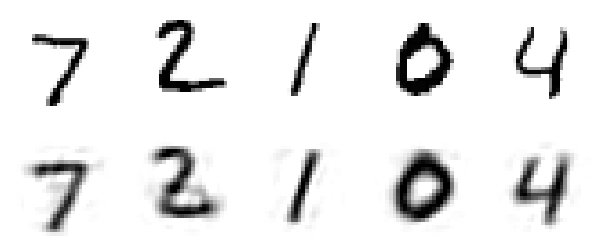

In [46]:
def plot_reconstructions(model, images, n_images=5):
    reconstructions = np.clip(model.predict(images[:n_images]), 0, 1)
    fig = plt.figure(figsize=(n_images * 1.5, 3))
    for image_index in range(n_images):
        plt.subplot(2, n_images, 1 + image_index)
        plt.imshow(images[image_index], cmap="binary")
        plt.axis("off")
        plt.subplot(2, n_images, 1 + n_images + image_index)
        plt.imshow(reconstructions[image_index], cmap="binary")
        plt.axis("off")

plot_reconstructions(variational_ae, images=x_test)
plt.show()

In [47]:
codings = tf.random.normal(shape=[3 * 7, LATENT_DIM])
images = variational_decoder(codings).numpy()

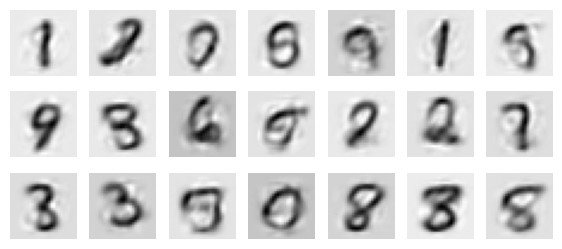

In [48]:
def plot_multiple_images(images, n_cols=None):
    n_cols = n_cols or len(images)
    n_rows = (len(images) - 1) // n_cols + 1
    if images.shape[-1] == 1:
        images = images.squeeze(axis=-1)
    plt.figure(figsize=(n_cols, n_rows))
    for index, image in enumerate(images):
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(image, cmap="binary")
        plt.axis("off")

plot_multiple_images(images, 7)
plt.show()

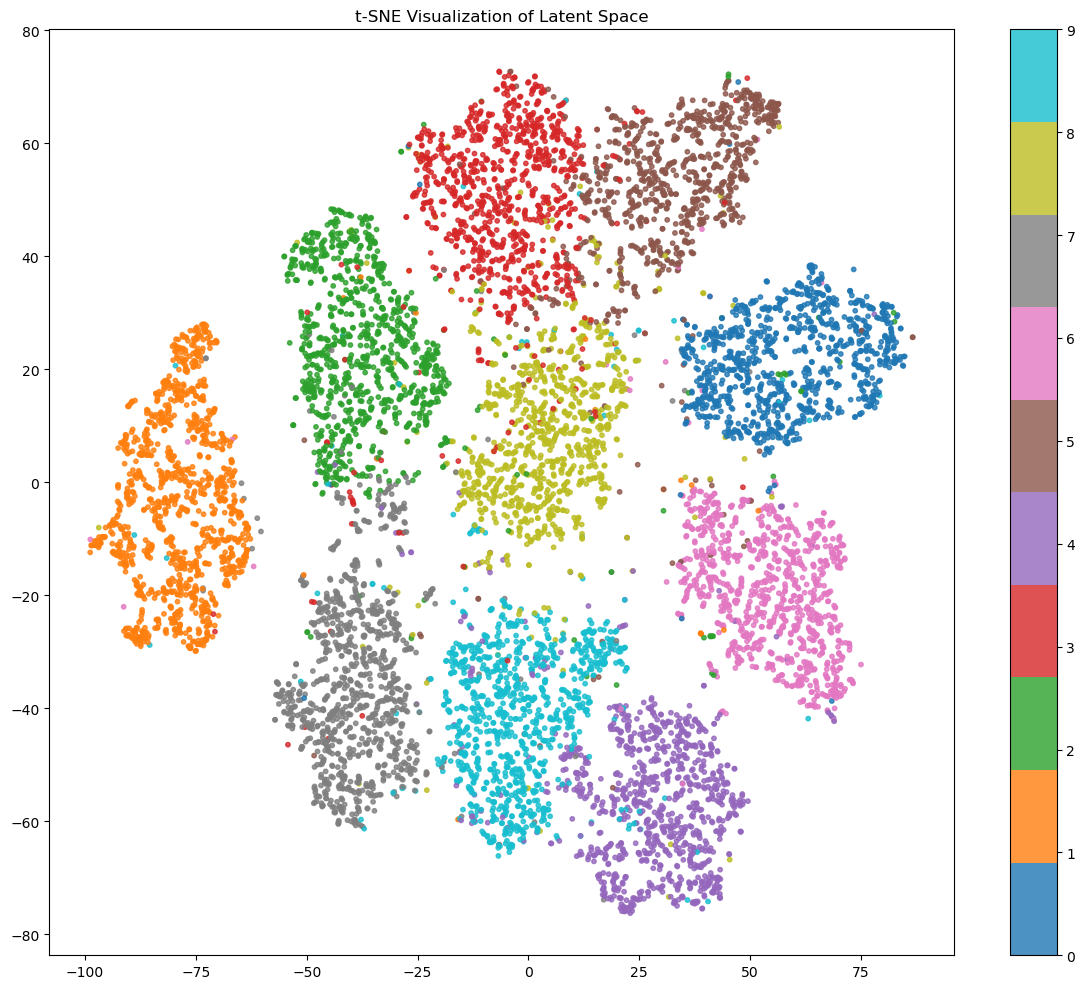

In [49]:
# Function for latent space exploration
n_samples = 2000

# Sample random test points
# indices = np.random.choice(len(x_test), n_samples, replace=False)
samples = x_test#[indices]
labels = y_test#[indices]

# Encode to latent space
codings_mean, codings_log_var, codings = variational_encoder(samples)

# Dimensionality reduction with t-SNE
tsne = TSNE(n_components=2, perplexity=30, learning_rate=200)
z_tsne = tsne.fit_transform(codings_mean)

# Plot
plt.figure(figsize=(12, 10))
scatter = plt.scatter(z_tsne[:, 0], z_tsne[:, 1], c=labels,
            cmap='tab10', s=10, alpha=0.8)
plt.colorbar(scatter, ticks=range(10))
plt.title("t-SNE Visualization of Latent Space")
plt.tight_layout()
plt.show()

In [50]:
variances = np.exp(codings_log_var.numpy())

average_variances = np.mean(variances, axis=0)

print("Average Variances per Latent Dimension:")
for i, avg_var in enumerate(average_variances):
    print(f"Dimension {i}: {avg_var:.4f}")

Average Variances per Latent Dimension:
Dimension 0: 0.1334
Dimension 1: 0.0508
Dimension 2: 0.9859
Dimension 3: 0.1333
Dimension 4: 0.0403
Dimension 5: 0.1531
Dimension 6: 0.3403
Dimension 7: 0.2910
Dimension 8: 0.5668
Dimension 9: 0.0303


In [51]:
threshold = 1e-3  # Adjust this threshold as needed
unused_dimensions = np.where(average_variances < threshold)[0]
print(f"\nPotentially Unused Dimensions (below threshold {threshold}): {unused_dimensions}")


Potentially Unused Dimensions (below threshold 0.001): []


In [52]:
# Perform clustering on the latent space
n_clusters = len(np.unique(y_test))  # Assuming the number of clusters equals the number of classes
kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
cluster_labels = kmeans.fit_predict(codings_mean)

# Compute the ARI
ari_score = adjusted_rand_score(labels, cluster_labels)
print(f"Adjusted Rand Index (ARI): {ari_score}")

Adjusted Rand Index (ARI): 0.4849913009797973


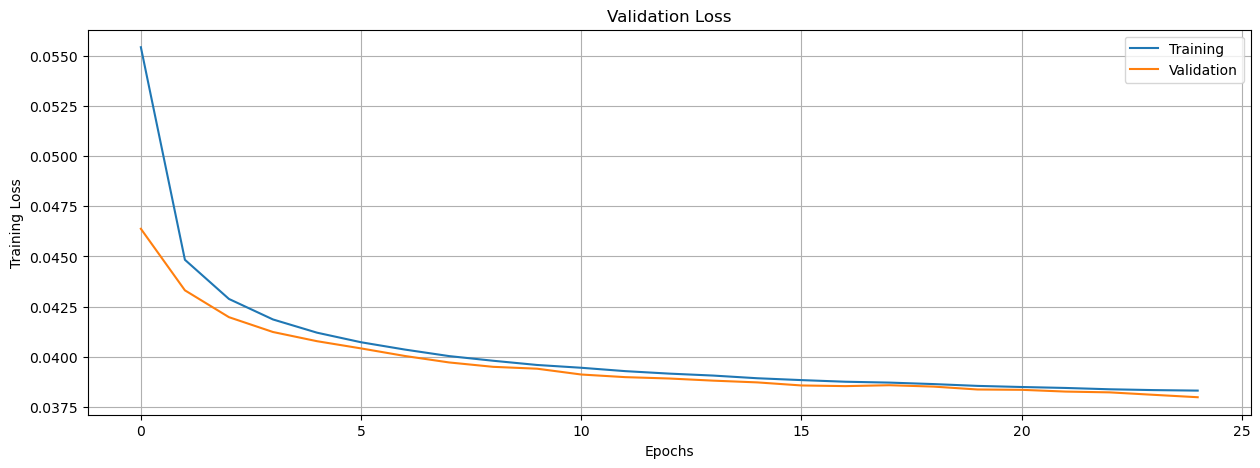

In [53]:
plt.figure(figsize=(15, 5))

plt.plot(history.history["loss"], label="Training")
plt.plot(history.history["val_loss"], label="Validation")
plt.xlabel("Epochs")
plt.ylabel("Training Loss")
plt.title("Validation Loss")
plt.legend()
plt.grid(True)
plt.show()